## AirBnB Project
In this project we are going to make a model for giving us insights on the price of an AirBnB in New York **(NY)** in America, with this dataset from kaggle.

For the Column that we will be using is as follows:
- neighbourhood
- neighbourhood group
- room type 
- price
- construction year
- availability 365
- minimum nights


By making the model we can make an interactive dashboard for user to interact with via streamlit.


Here is the Dataset Link: https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata?resource=download


In [119]:
# importing the necesarry libraries

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import random #this is for the visual color

# Preprocessing and model utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.ensemble import RandomForestRegressor  # Changed from Classifier to Regressor
import xgboost as xgb

### Knowing the Dataset

In [120]:
data = pd.read_csv("Airbnb_Open_Data.csv")
data.head()

/tmp/ipykernel_155263/1113942449.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Airbnb_Open_Data.csv")


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

In [122]:
# Now we're going to see if theres any null/missing values and duplicate 
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_summary = pd.DataFrame({
    'Column': data.columns,
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': missing_percentage
}).sort_values('Missing Percentage', ascending=False)

print("Missing Values Summary:")
print(missing_summary[missing_summary['Missing Percentage'] > 0])

Missing Values Summary:
                                                        Column  Missing Count  \
license                                                license         102597   
house_rules                                        house_rules          52131   
last review                                        last review          15893   
reviews per month                            reviews per month          15879   
country                                                country            532   
availability 365                              availability 365            448   
minimum nights                                  minimum nights            409   
host name                                            host name            406   
review rate number                          review rate number            326   
calculated host listings count  calculated host listings count            319   
host_identity_verified                  host_identity_verified            289   
serv

In [123]:
# Clean 'price' column before filling missing values
if 'price' in data.columns:
    data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)
    
# Fill numeric missing values with median
for col in ['price', 'Construction year', 'availability 365', 'minimum nights']:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert price if it's object
    data[col].fillna(data[col].median(), inplace=True)

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_155263/1206382065.py:3: SyntaxWarning: invalid escape sequence '\$'
  data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)
/tmp/ipykernel_155263/1206382065.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


I'll just drop the Categorical missing values of the relevant columns, and fill the Numerical missing values with **median**. The missing data itself is under 1%, so i thought the categorical data can be drop same with the numerical but i would rather fill it in (*personal preference btw*). 

In [124]:
# Find duplicates based on all columns
full_duplicates = data[data.duplicated(keep=False)]
print("Full duplicates (all columns):")
print(full_duplicates)

# Find duplicates ignoring the 'id' column
duplicates_no_id = data[data.duplicated(subset=data.columns.difference(['id']), keep=False)]
print("Duplicates ignoring 'id':")
print(duplicates_no_id)

# Optional: see a summary count by host or listing
summary = duplicates_no_id.groupby(['host id', 'NAME']).size().reset_index(name='count')
summary = summary[summary['count'] > 1]
print(summary)


Full duplicates (all columns):
             id                                               NAME  \
9098    6026161     Upper East Side 2 bedroom- close to Hospitals-   
9099    6026714  Close to East Side Hospitals- Modern 2 Bedroom...   
9100    6027266  ACADIA Spacious 2 Bedroom Apt - Close to Hospi...   
9101    6027818    *ENCHANTMENT* Upper East Side 2 bedroom- Sunny!   
9102    6028371        *JAMES* Amazing Spacious 2 Bedroom- Bright!   
...         ...                                                ...   
102594  6092437                         Spare room in Williamsburg   
102595  6092990                      Best Location near Columbia U   
102596  6093542                     Comfy, bright room in Brooklyn   
102597  6094094                   Big Studio-One Stop from Midtown   
102598  6094647                               585 sf Luxury Studio   

            host id host_identity_verified    host name neighbourhood group  \
9098    65193709566               verified      J

Since this type of duplicates aren't true duplicates of the same listing, I thought I should just leave it as is

### Splitting Data into Numerical and Categorical

In [125]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

In [126]:
numeric_data

,id,host id,lat,long,Construction year,price,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
0,1001254,80014485718,40.64749,-73.97237,2020.0,966.0,10.0,9.0,0.21,4.0,6.0,286.0
1,1002102,52335172823,40.75362,-73.98377,2007.0,142.0,30.0,45.0,0.38,4.0,2.0,228.0
2,1002403,78829239556,40.80902,-73.94190,2005.0,620.0,3.0,0.0,NaN,5.0,1.0,352.0
3,1002755,85098326012,40.68514,-73.95976,2005.0,368.0,30.0,270.0,4.64,4.0,1.0,322.0
4,1003689,92037596077,40.79851,-73.94399,2009.0,204.0,10.0,9.0,0.10,3.0,1.0,289.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102594,6092437,12312296767,40.70862,-73.94651,2003.0,844.0,1.0,0.0,NaN,3.0,1.0,227.0
102595,6092990,77864383453,40.80460,-73.96545,2016.0,837.0,1.0,1.0,0.02,2.0,2.0,395.0
102596,6093542,69050334417,40.67505,-73.98045,2009.0,988.0,3.0,0.0,NaN,5.0,1.0,342.0
102597,6094094,11160591270,40.74989,-73.93777,2015.0,546.0,2.0,5.0,0.10,3.0,1.0,386.0


In [127]:
categorical_data

,NAME,host_identity_verified,host name,neighbourhood group,neighbourhood,country,country code,instant_bookable,cancellation_policy,room type,service fee,last review,house_rules,license
0,Clean & quiet apt home by the park,unconfirmed,Madaline,Brooklyn,Kensington,United States,US,False,strict,Private room,$193,10/19/2021,Clean up and treat the home the way you'd like...,NaN
1,Skylit Midtown Castle,verified,Jenna,Manhattan,Midtown,United States,US,False,moderate,Entire home/apt,$28,5/21/2022,Pet friendly but please confirm with me if the...,NaN
2,THE VILLAGE OF HARLEM....NEW YORK !,NaN,Elise,Manhattan,Harlem,United States,US,True,flexible,Private room,$124,NaN,"I encourage you to use my kitchen, cooking and...",NaN
3,NaN,unconfirmed,Garry,Brooklyn,Clinton Hill,United States,US,True,moderate,Entire home/apt,$74,7/5/2019,NaN,NaN
4,Entire Apt: Spacious Studio/Loft by central park,verified,Lyndon,Manhattan,East Harlem,United States,US,False,moderate,Entire home/apt,$41,11/19/2018,"Please no smoking in the house, porch or on th...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102594,Spare room in Williamsburg,verified,Krik,Brooklyn,Williamsburg,United States,US,False,flexible,Private room,$169,NaN,No Smoking No Parties or Events of any kind Pl...,NaN
102595,Best Location near Columbia U,unconfirmed,Mifan,Manhattan,Morningside Heights,United States,US,True,moderate,Private room,$167,7/6/2015,House rules: Guests agree to the following ter...,NaN
102596,"Comfy, bright room in Brooklyn",unconfirmed,Megan,Brooklyn,Park Slope,United States,US,True,moderate,Private room,$198,NaN,NaN,NaN
102597,Big Studio-One Stop from Midtown,unconfirmed,Christopher,Queens,Long Island City,United States,US,True,strict,Entire home/apt,$109,10/11/2015,NaN,NaN


### Visualization of Categorical and Numerical Data

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_155263/4219077024.py:4: SyntaxWarning: invalid escape sequence '\$'
  data[col] = data[col].replace('[\$,]', '', regex=True).astype(float)


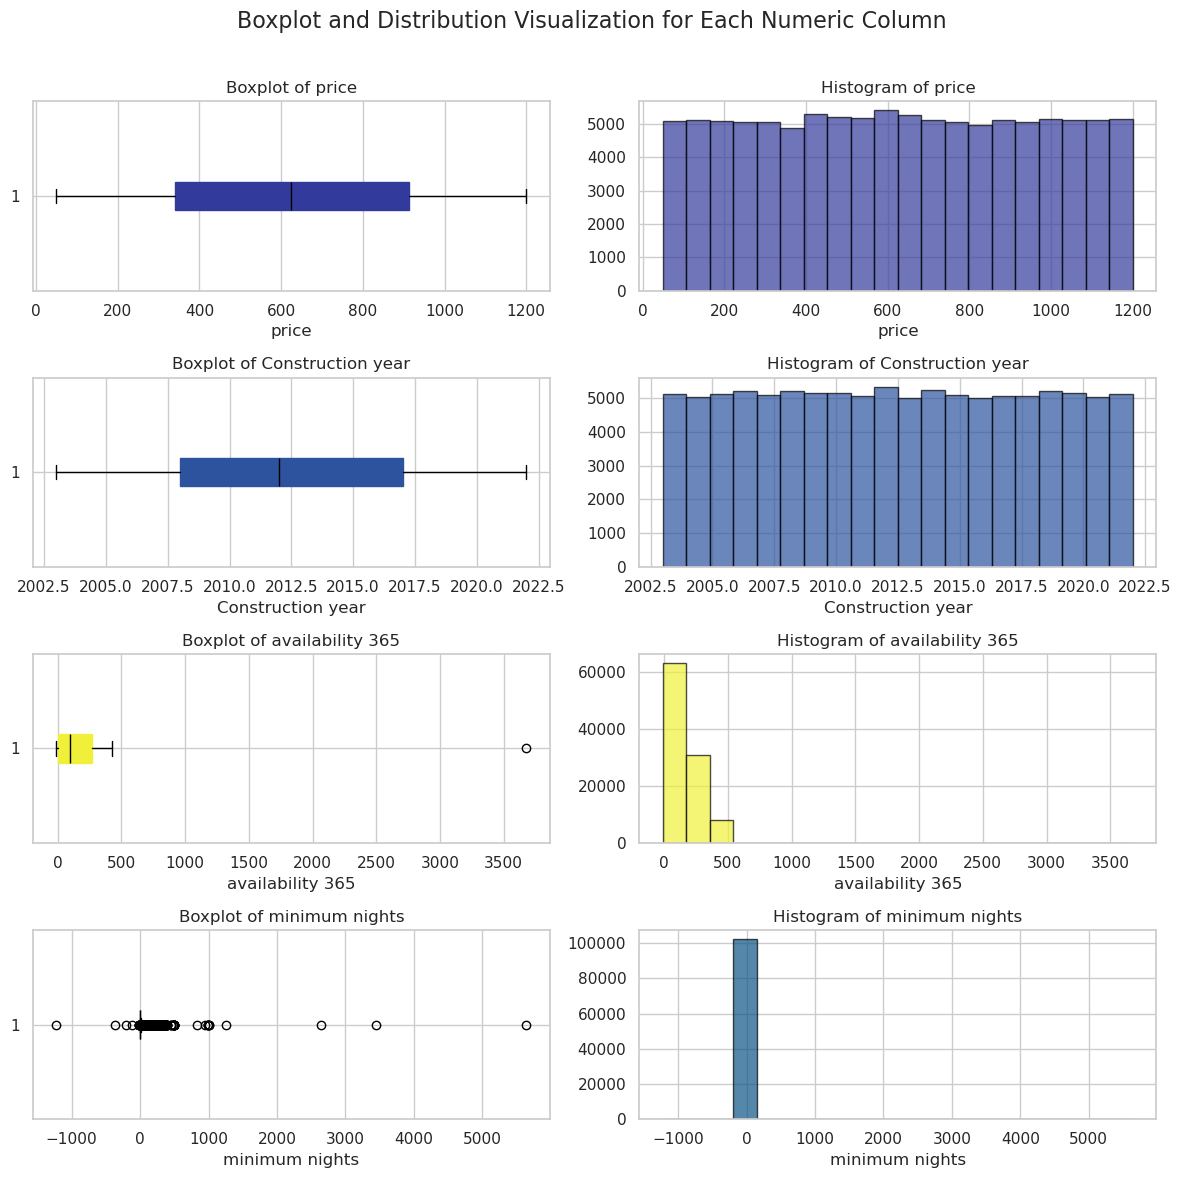

In [128]:
# Convert price and service fee to numeric
for col in ['price', 'service fee']:
    if col in data.columns:
        data[col] = data[col].replace('[\$,]', '', regex=True).astype(float)

# Relevant numeric columns
numeric_cols = ['price', 'Construction year', 'availability 365', 'minimum nights']

# Function to generate random color
def fill_color_generator():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

fill_color_dict = {col: fill_color_generator() for col in numeric_cols}

# Subplots
num_rows = len(numeric_cols)
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))
axes = axes if num_rows > 1 else [axes]

for i, column in enumerate(numeric_cols):
    color = fill_color_dict[column]

    # Boxplot
    axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
    axes[i][0].set_title(f"Boxplot of {column}")
    axes[i][0].set_xlabel(column)

    # Histogram
    axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
    axes[i][1].set_title(f"Histogram of {column}")
    axes[i][1].set_xlabel(column)

# Overall layout
fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Here's what I observe about the visualizations:

For Overview what this plot is about:
1. **Boxplots** show the spread, median, and potential outliers of each variable. 

2. **Histograms** on the right side of each boxplot give more granular insight into the frequency of the values for each attribute, showing how they are distributed across the dataset.

### Key observations:

* **Price**: Appears to show a fairly distribution with uniform distribution, means the price range is relaticely consistent.
* **Construction Year**: Appears to show a fairly uniform distribution with a slight preference for more recent constructions.
* **Minimum Nights**: There are clear outliers with many listings requiring very few nights, while others have extreme values in the thousands.
* **Availability 365**: This shows a highly skewed distribution, with many properties having low availability (close to 0), while some have very high availability (close to 365).



In [129]:
# Before we plot the categorical data, we need to tinker it a bit.
for col in categorical_data.columns:        
    print(f"Unique values in {col}: {categorical_data[col].unique()}")

Unique values in NAME: ['Clean & quiet apt home by the park' 'Skylit Midtown Castle'
 'THE VILLAGE OF HARLEM....NEW YORK !' ...
 'Elmhurst 1st Fl Rightl Bedroom'
 'Elmhurst 1st Floor BR w/ Pvt. Bath&Balcony'
 'Parisian Style Apartment in Heart of Brooklyn']
Unique values in host_identity_verified: ['unconfirmed' 'verified' nan]
Unique values in host name: ['Madaline' 'Jenna' 'Elise' ... 'Anna B' 'Natalie And Dan' 'Apostle John']
Unique values in neighbourhood group: ['Brooklyn' 'Manhattan' 'brookln' 'manhatan' 'Queens' nan 'Staten Island'
 'Bronx']
Unique values in neighbourhood: ['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper

/tmp/ipykernel_155263/665714459.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=data, order=data[col].value_counts().index, palette="viridis")


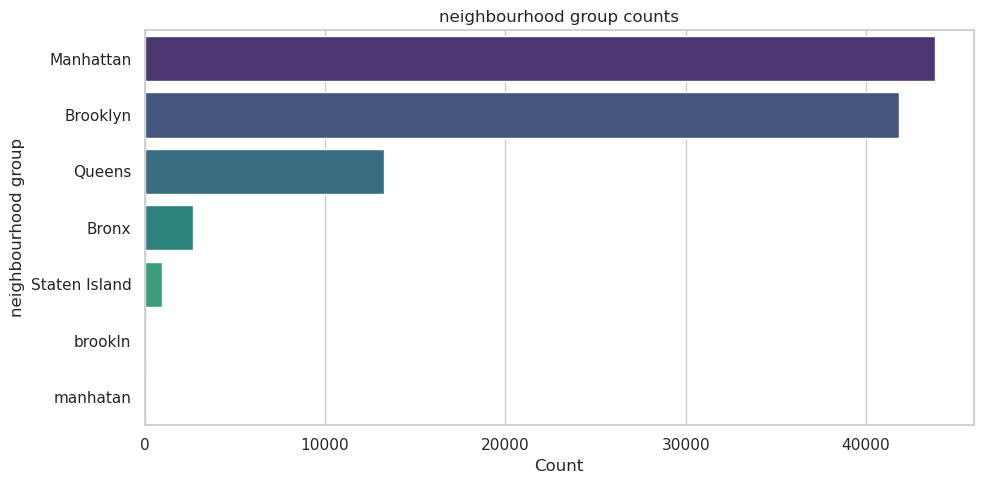

/tmp/ipykernel_155263/665714459.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="viridis")


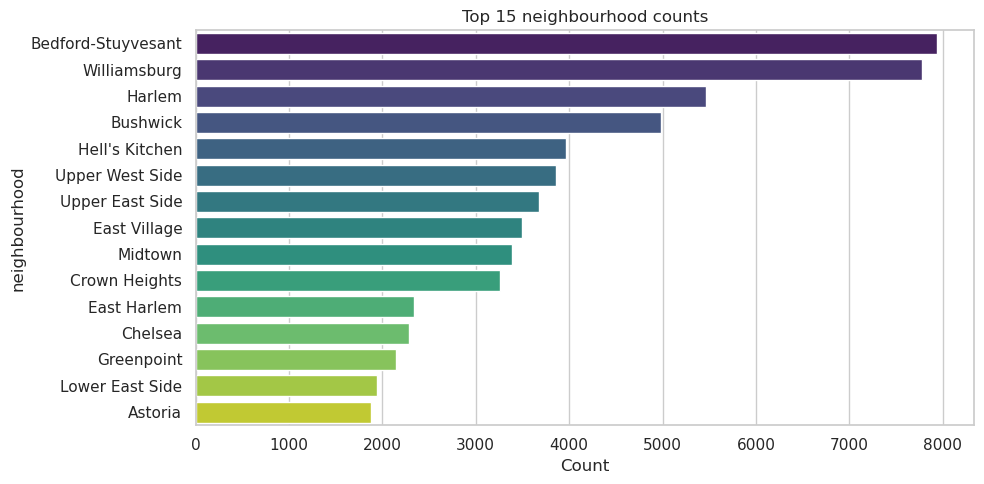

/tmp/ipykernel_155263/665714459.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=data, order=data[col].value_counts().index, palette="viridis")


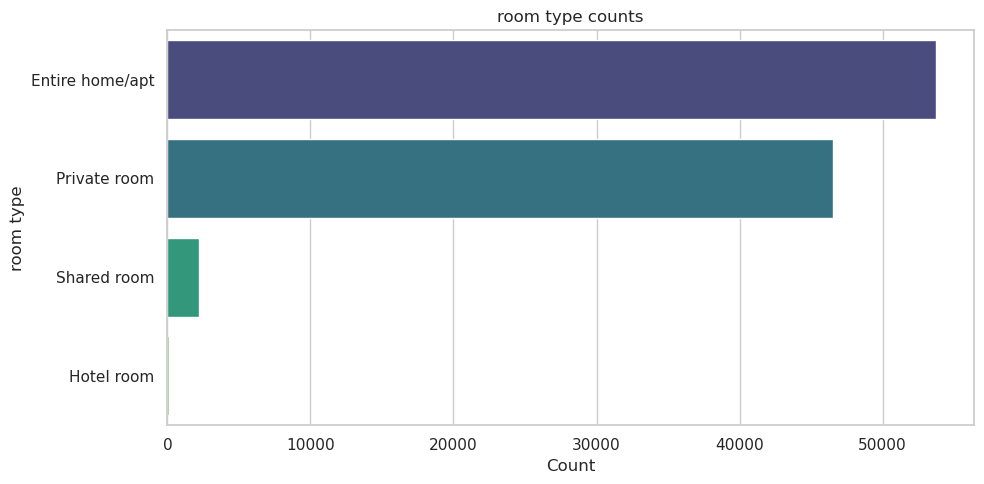

In [130]:
# Relevant categorical columns
categorical_cols = ['neighbourhood group', 'neighbourhood', 'room type']

# Set seaborn style
sns.set(style="whitegrid")

#now plot
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    
    if col == 'neighbourhood':
        # For neighbourhood, show top 15 most frequent
        top_values = data[col].value_counts().nlargest(15)
        sns.barplot(x=top_values.values, y=top_values.index, palette="viridis")
        plt.title(f"Top 15 {col} counts")
    else:
        # For other categorical columns
        sns.countplot(y=col, data=data, order=data[col].value_counts().index, palette="viridis")
        plt.title(f"{col} counts")
    
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

Here's what I observe from this visualization:

### Keypoints:
* **Neighborhood Group Counts**: The first chart shows the distribution of listings across neighborhoods, with Manhattan having the most listings, followed by Brooklyn and Queens.
* **Top 15 Neighborhood Counts**: This chart displays the top neighborhoods by the number of listings, with Bedford-Stuyvesant leading, followed by Williamsburg, Harlem, and others.
* **Room Type Counts**: The chart displays the distribution of room types, with "Entire home/apt" having the highest count, followed by "Private room."


### Feature Engineering For Dashboard

In [131]:
#Create property age
data["property_age"] = 2025 - data["Construction year"]


In [132]:
# Handle Outliers
# Cap extreme prices
data = data[data["price"] < 1000]  # keep only listings below $1000

# Cap minimum nights
data = data[data["minimum nights"] < 365]


In [133]:
data["price_category"] = pd.cut(data["price"], 
                              bins=[0, 100, 300, 1000], 
                              labels=["Low", "Medium", "High"])


In [134]:
avg_price = data.groupby(["neighbourhood", "room type"])["price"].mean().reset_index()


In [135]:
data.to_csv("airbnb_cleaned.csv", index=False)
